In [1]:
import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt

np.random.seed(41)
torch.manual_seed(41)

In [2]:
sen_len = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn((batch_size, sen_len, input_dim))
print(f"size of x: {x.shape}")

size of x: torch.Size([1, 4, 512])


In [3]:
qkv_layer = nn.Linear(input_dim, input_dim * 3)
qkv = qkv_layer(x)
x.shape,qkv.shape

(torch.Size([1, 4, 512]), torch.Size([1, 4, 1536]))

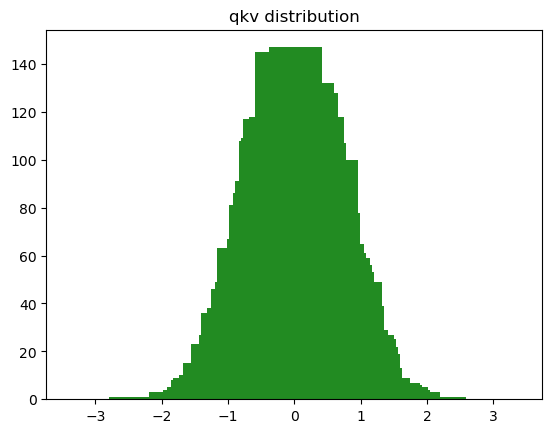

In [4]:
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.linspace(-3, 3, 200)
plt.bar(x_val, y_val, align="center", color=["forestgreen"])
plt.title("qkv distribution");

## Actual breaking down of heads

We are reshaping then permuting it.... Well we can simply skip the steps and do only 1 reshape, but it's done for more clarity of the computations.

In [5]:
n_head = 8
head_dim = d_model// n_head
print(f"Original qkv {qkv.shape}")
n_qkv = qkv.reshape(batch_size, sen_len, n_head, 3*head_dim)
print(f"Adter transforming qkv {n_qkv.shape}")

Original qkv torch.Size([1, 4, 1536])
Adter transforming qkv torch.Size([1, 4, 8, 192])


Now permuting to perform the actual calculations,
We could have directly achieved this by simply reshaping to this size, but for more clarity of how the heads are calculated and computed this is done, which means both the approaches are same (essentially)

In [6]:
n_qkv = n_qkv.permute(0, 2, 1, 3)

In [7]:
q, k, v = n_qkv.chunk(3, dim=-1)
q.shape

torch.Size([1, 8, 4, 64])

## Attention for Encoder

In [8]:
d_k = torch.tensor(q.shape[-1])
att = (q @ k.transpose(-2, -1))/ torch.sqrt(d_k)
e_att = F.softmax(att, dim=-1)
att.shape, e_att[0][0]

(torch.Size([1, 8, 4, 4]),
 tensor([[0.1948, 0.1928, 0.2872, 0.3253],
         [0.2100, 0.3209, 0.2571, 0.2120],
         [0.2078, 0.2499, 0.3382, 0.2041],
         [0.1438, 0.3906, 0.2483, 0.2172]], grad_fn=<SelectBackward0>))

## Attention for Decoder

We essentially have to make n_head masks.
The below code does that

In [9]:
mask = torch.full(att.size(), float('-inf'))
print(f"Shape of mask: {mask.shape}")
print("Before: ")
print(mask[0][0])
mask = torch.triu(mask, diagonal=1)
print("After: ")
print(mask[0][0])

d_att = att + mask
d_att = F.softmax(d_att, dim=-1)
d_att[0][0]

Shape of mask: torch.Size([1, 8, 4, 4])
Before: 
tensor([[-inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf]])
After: 
tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])


tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.3956, 0.6044, 0.0000, 0.0000],
        [0.2611, 0.3140, 0.4250, 0.0000],
        [0.1438, 0.3906, 0.2483, 0.2172]], grad_fn=<SelectBackward0>)

## New Embeddings

In [10]:
print(f"Value: {v.shape}")
print(f"Att: {e_att.shape}")

(e_att @ v).shape

Value: torch.Size([1, 8, 4, 64])
Att: torch.Size([1, 8, 4, 4])


torch.Size([1, 8, 4, 64])

In [11]:
a = torch.randn(2, 4)
a, a.reshape(2, 2, 2)

(tensor([[ 0.8006, -0.6418, -0.1825, -0.4408],
         [ 0.6390, -1.5435, -0.2133,  0.4794]]),
 tensor([[[ 0.8006, -0.6418],
          [-0.1825, -0.4408]],
 
         [[ 0.6390, -1.5435],
          [-0.2133,  0.4794]]]))

## Combining everything into a class

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 input_dim: int,
                 d_model: int,
                 n_head: int):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.n_head = n_head
        self.h_dim = d_model // n_head
        self.qkv_layer = nn.Linear(input_dim, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self,
                x: torch.tensor,
                mask: torch.tensor = None):
        B, sen_len, input_dim = x.size()
        qkv = self.qkv_layer(x) # B, sen_len, 3 * d_model
        qkv = qkv.reshape(B, sen_len, self.n_head, self.h_dim * 3)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        d_k = q.size()[-1]
        att = (q @ k.transpose(-2, -1))/ torch.sqrt(torch.tensor(d_k))
        if mask is not None:
            att += mask
        att = F.softmax(att, dim=-1)
        new_emb = att @ v
        print(f"New emb: {new_emb.shape}")
        new_emb = new_emb.reshape(B, sen_len, self.n_head * self.h_dim)
        print(f"New emb: {new_emb.shape}")
        new_emb = self.linear_layer(new_emb)
        return att, new_emb
        
mb = MultiHeadAttention(input_dim=512,
                        d_model=512,
                        n_head=8)
a = torch.randn((1, 4, 512))
att, new_emb = mb(a)
att.shape, new_emb.shape

New emb: torch.Size([1, 8, 4, 64])
New emb: torch.Size([1, 4, 512])


(torch.Size([1, 8, 4, 4]), torch.Size([1, 4, 512]))